# 1. Import required packages and required input data

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
import pandas as pd
data = pd.read_csv('timeSeries_TSA.csv', index_col = 0).reset_index(drop=True)

%matplotlib inline  
%load_ext autoreload
%autoreload 2

list(data)
data['E-Load\r\nIsland [kW]'].sum()

6199520.972202418

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'Island'}
commodityUnitDict = {'electricity': r'kW$_{el}$', 'hydrogen': r'kW$_{H_{2}}$'}
commodities = {'electricity', 'hydrogen'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1 Euro', lengthUnit='km', verboseLogLevel=0)

# 3. Add Commodity Sources and Sinks

### Wind onshore

In [4]:
esM.add(fn.Source(esM=esM, name='Wind', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind\r\n[kW/kWp]'],
                  investIfBuilt=1e5, investPerCapacity=1e3, opexPerCapacity=1e3*0.02, interestRate=0.08,
                  economicLifetime=20))

### PV

In [5]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Photovoltaic\r\n[kW/kWp]'],
                  investIfBuilt=1e4, investPerCapacity=800, opexPerCapacity=800*0.01, interestRate=0.08,
                  economicLifetime=20))

### Backup Plant

In [6]:
esM.add(fn.Source(esM=esM, name='Backup Plant', commodity='electricity',
                commodityLimitID="Electricity Import",
                yearlyLimit=-0.1*data['E-Load\r\nIsland [kW]'].sum(),
                hasCapacityVariable=False, commodityCost=0.2, economicLifetime=25))

### E-Demand

In [7]:
esM.add(fn.Sink(esM=esM, name='Electricity Demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['E-Load\r\nIsland [kW]']))

# 4. Add Conversion Components

### Electrolyzers

In [8]:
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'kW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investIfBuilt=1e5, investPerCapacity=500, opexPerCapacity=500*0.03, interestRate=0.08,
                      economicLifetime=15))

### Fuel Cells

In [9]:
esM.add(fn.Conversion(esM=esM, name='Fuel Cells', physicalUnit=r'kW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.5},
                      hasCapacityVariable=True, 
                      investIfBuilt=1e5, investPerCapacity=1100, opexPerCapacity=1100*0.03, interestRate=0.08,
                      economicLifetime=15))

# 5. Add Storage Components

### Battery

In [10]:
esM.add(fn.Storage(esM=esM, name='Battery', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.96,
                   dischargeEfficiency=0.96, selfDischarge=5e-4,
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=300, opexPerCapacity=300*0.01, interestRate=0.08,
                   economicLifetime=15))

### H2 Storage

In [11]:
esM.add(fn.Storage(esM=esM, name='Hydrogen Vessel', commodity='hydrogen',
                   hasCapacityVariable=True, chargeEfficiency=0.9,
                   dischargeEfficiency=1, selfDischarge=0,
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=15, opexPerCapacity=0, interestRate=0.08,
                   economicLifetime=25))

# 6. Optimize energy system model

In [12]:
esM.optimize(timeSeriesAggregation=False, solver='gurobi')

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(2.1684 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.6396 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(2.8392 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring commodity balances...
		(1.3436 sec)

Declaring objective function...
		(1.2324 sec)

Academic license - for non-commercial use only
Read LP format model from file C:\Users\m.hoffmann\Documents\Workspace\FINE\examples\Island System\tmpg81n9hjg.pyomo.lp
Reading time = 0.59 seconds
x105135: 148930 rows, 105135 columns, 380085 nonzeros
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Changed value of parameter logfile to 
   Prev: gurobi.log  Default: 
Ch

# 7. Selected results output

Show optimization summary

### Sources and Sinks

In [13]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

Island
Component          Property    Unit                        
Backup Plant       TAC         [1 Euro/a]            123990
                   commodCosts [1 Euro/a]            123990
                   operation   [kW$_{el}$*h/a]       619952
Electricity Demand operation   [kW$_{el}$*h/a]  6.19952e+06
PV                 TAC         [1 Euro/a]            293184
                   capacity    [kW$_{el}$]          3276.46
                   capexCap    [1 Euro/a]            266972
                   invest      [1 Euro]         2.62117e+06
                   operation   [kW$_{el}$*h/a]  3.05404e+06
                   opexCap     [1 Euro/a]           26211.7
Wind               TAC         [1 Euro/a]            322276
                   capacity    [kW$_{el}$]          2644.81
                   capexCap    [1 Euro/a]            269380
                   invest      [1 Euro]         2.64481e+06
                   operation   [kW$_{el}$*h/a]  3.94681e+06
                   opexCap     [1 Euro/a]           52896.2

### Conversion Units

In [14]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

Island
Component     Property  Unit                        
Electroylzers TAC       [1 Euro/a]           51036.9
              capacity  [kW$_{el}$]          695.186
              capexCap  [1 Euro/a]           40609.1
              invest    [1 Euro]              347593
              operation [kW$_{el}$*h/a]  1.90931e+06
              opexCap   [1 Euro/a]           10427.8
Fuel Cells    TAC       [1 Euro/a]           39076.9
              capacity  [kW$_{el}$]          241.943
              capexCap  [1 Euro/a]           31092.7
              invest    [1 Euro]              266138
              operation [kW$_{el}$*h/a]       585777
              opexCap   [1 Euro/a]           7984.13

### Storages

In [15]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

Island
Component       Property           Unit                           
Battery         TAC                [1 Euro/a]               137293
                capacity           [kW$_{el}$*h]           3608.34
                capexCap           [1 Euro/a]               126468
                invest             [1 Euro]             1.0825e+06
                operationCharge    [kW$_{el}$*h/a]     1.18202e+06
                operationDischarge [kW$_{el}$*h/a]     1.08427e+06
                opexCap            [1 Euro/a]                10825
Hydrogen Vessel TAC                [1 Euro/a]                55962
                capacity           [kW$_{H_{2}}$*h]        39825.5
                capexCap           [1 Euro/a]                55962
                invest             [1 Euro]                 597382
                operationCharge    [kW$_{H_{2}}$*h/a]   1.6496e+06
                operationDischarge [kW$_{H_{2}}$*h/a]  1.48464e+06

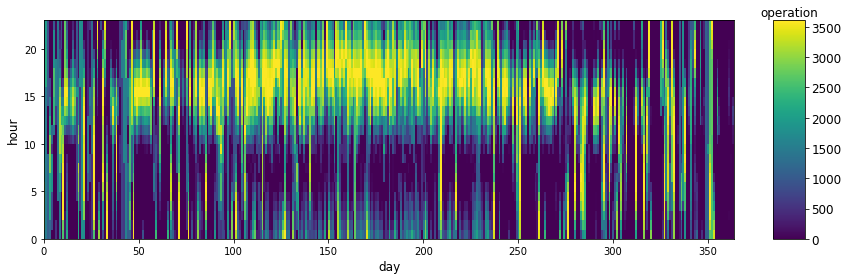

In [19]:
fig, ax = fn.plotOperationColorMap(esM, 'Battery', 'Island',
                                  variableName='stateOfChargeOperationVariablesOptimum')

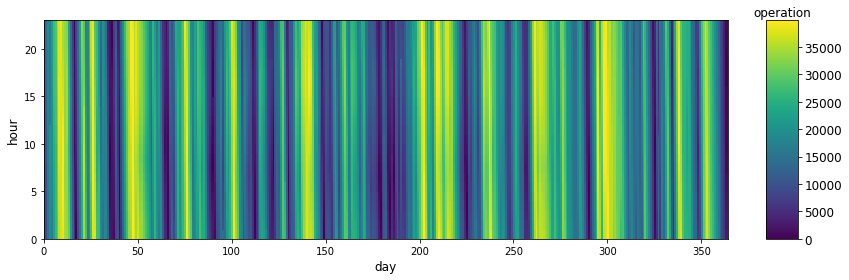

In [20]:
fig, ax = fn.plotOperationColorMap(esM, 'Hydrogen Vessel', 'Island',
                                  variableName='stateOfChargeOperationVariablesOptimum')